If you are interested in graident boosting, here is a good place to start: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

This is a supervised machine learning method.

# Predicting K

In [1]:
!pip install xgboost --upgrade

     |████████████████████████████████| 157.5MB 93kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
# If you have installation questions, please reach out

import pandas as pd # data storage
import xgboost      # graident boosting 
import numpy as np  # math and stuff

import seaborn as sns
import scipy.stats as stats

import xgboost as xgb

import sklearn  
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, max_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt # plotting utility

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ls

drive/  sample_data/


In [5]:
df = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/Merged_dataset_inner_imputed_12_21_2020.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'LiveTime2','ScanTime2', 'LiveTime1','ScanTime1',
              'ref_num', 'API', 'well_name', 'sample_num' ], axis=1)

print(df.columns.values) # printing all column names

df.describe()

['depth_ft' 'USGS_ID' 'CAL' 'GR' 'DT' 'SP' 'DENS' 'PE' 'RESD' 'PHIN'
 'PHID' 'PE_smooth' 'GR_smooth' 'gz_linear_interp' 'gz_pchip_interp'
 'perm_air_md' 'perm_klink_md' 'He_por' 'horz_perm_md' 'effective_por'
 'por_percent' 'stress_swanson_perm_md' 'sample' 'Na' 'Na Err' 'Mg'
 'Mg Err' 'Al' 'Al Err' 'Si' 'Si Err' 'P' 'P Err' 'S' 'S Err' 'K' 'K Err'
 'Ca' 'Ca Err' 'Ti' 'Ti Err' 'Cr' 'Cr Err' 'Mn' 'Mn Err' 'Fe' 'Fe Err'
 'Co' 'Co Err' 'Ni' 'Ni Err' 'Cu' 'Cu Err' 'Zn' 'Zn Err' 'Ba' 'Ba Err']


,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,508.000000,510.000000,510.000000,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,5397.863358,0.468406,0.325999,0.430844,0.811259,0.613371,0.351642,1.011018,0.172737,0.172737,0.351702,0.326029,4.913576,4.910244,81.002187,73.797216,14.267039,8.304000,11.808000,8.420833,1.646585,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689
std,5106.156677,0.191316,0.237404,0.263514,0.162843,0.214604,0.186912,1.503608,0.226664,0.226664,0.178735,0.229901,1.738128,1.751499,173.917355,161.251984,9.365678,3.161814,4.446902,3.050728,3.741652,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594
min,150.000000,0.000000,0.000000,0.003752,0.000000,0.000000,0.000000,-0.744314,0.000570,0.000570,0.004477,0.000258,1.204296,1.199972,0.001000,0.000000,1.000000,1.900000,5.900000,4.000000,0.000390,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100
25%,450.725000,0.360072,0.122318,0.174146,0.743878,0.424460,0.216157,-0.037336,0.004595,0.004595,0.220800,0.131058,3.538724,3.531571,0.040750,0.020250,8.300000,7.900000,8.400000,6.800000,0.001140,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300
50%,1614.650000,0.554827,0.275825,0.471657,0.867010,0.605516,0.329327,0.795008,0.005532,0.005532,0.337049,0.283192,4.307541,4.256191,0.065500,0.037500,9.300000,9.500000,10.600000,7.300000,0.002070,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.003100,0.001200,0.0,0.004800,0.000100,0.000000,0.000800,0.005400,0.000800,0.079300,0.004700
75%,9649.575000,0.602566,0.530980,0.662807,0.925012,0.830179,0.470706,1.378387,0.332503,0.332503,0.463317,0.525448,6.615175,6.633493,71.375000,59.675000,26.610000,10.300000,13.800000,9.200000,0.949777,1.322750,0.026700,1.192400,0.014400,4.531475,0.014400,37.944075,0.034700,0.061800,0.002000,0.941100,0.002900,2.291400,0.006900,3.872700,0.007000,0.258025,0.001600,0.006800,0.000100,0.023400,0.000800,2.616775,0.003900,0.001700,0.0,0.005200,0.000100,0.006300,0.000900,0.009200,0.0

In [7]:
df = df[df.K >= 0]

In [ ]:
# df = df[df.USGS_ID != 'E997'] # removing E997

In [8]:
df.USGS_ID.unique()

array(['F028', 'E952', 'E945', 'E974', 'F041', 'F042', 'E934', 'E997',
       'S821', 'CEPO', 'S179', 'PDRMT'], dtype=object)

In [9]:
df.describe()

,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err
count,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,278.000000,278.000000,278.000000,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,5381.097037,0.468367,0.325982,0.431237,0.811337,0.613171,0.351816,1.011043,0.172725,0.172725,0.351716,0.326086,4.929909,4.927045,10.063730,9.155464,9.206727,8.304000,11.808000,8.420833,1.646585,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689
std,5101.029774,0.191645,0.237586,0.263125,0.163012,0.214509,0.187277,1.499012,0.227024,0.227024,0.178678,0.229953,1.742970,1.756868,71.398097,66.537002,4.492513,3.161814,4.446902,3.050728,3.741652,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594
min,150.000000,0.000000,0.000000,0.003880,0.007154,0.001136,0.000098,-0.744314,0.000664,0.000664,0.004685,0.000377,1.238052,1.231032,0.001000,0.001000,1.000000,1.900000,5.900000,4.000000,0.000390,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100
25%,450.375000,0.362761,0.121491,0.176235,0.743371,0.423086,0.216361,-0.033914,0.004595,0.004595,0.220855,0.131464,3.541975,3.534175,0.034000,0.016250,7.900000,7.900000,8.400000,6.800000,0.001140,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300
50%,1613.250000,0.554827,0.275724,0.472182,0.867582,0.605516,0.329464,0.801593,0.005520,0.005520,0.335836,0.282739,4.325345,4.295978,0.059000,0.033000,9.000000,9.500000,10.600000,7.300000,0.002070,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.003100,0.001200,0.0,0.004800,0.000100,0.000000,0.000800,0.005400,0.000800,0.079300,0.004700
75%,9484.625000,0.602566,0.530504,0.662435,0.924986,0.830135,0.470435,1.378201,0.332579,0.332579,0.462545,0.525624,6.621108,6.636347,0.072750,0.041000,9.800000,10.300000,13.800000,9.200000,0.949777,1.322750,0.026700,1.192400,0.014400,4.531475,0.014400,37.944075,0.034700,0.061800,0.002000,0.941100,0.002900,2.291400,0.006900,3.872700,0.007000,0.258025,0.001600,0.006800,0.000100,0.023400,0.000800,2.616775,0.003900,0.001700,0.0,0.005200,0.000100,0.006300,0.000900,0.009200,0.000800,0.106600,0.0051

## Loading in dataset

In [10]:
dataset = df[[
    'depth_ft', 'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
       'RESD', 'PHIN', 'PHID', 
       'GR_smooth', 
       'PE_smooth',
       'K'
]]

In the next code block, we will remove the rows without data, and change string NaN's to np.nans

In [11]:
dataset.replace('NaN',np.nan, regex=True, inplace=True)# 
#dataset = dataset.dropna()
np.shape(dataset)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


(2396, 13)

In [12]:
dataset.head(3)

,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,K
0,7741.0,0.630495,0.187403,0.054025,0.582081,0.829176,0.349137,0.982069,0.001692,0.001692,0.183350,0.366294,0.9947
5,7741.5,0.626112,0.182393,0.063209,0.586778,0.825487,0.351442,0.922670,0.001810,0.001810,0.196369,0.357995,1.0616
10,7742.0,0.621729,0.184446,0.063426,0.590484,0.825878,0.402086,0.886733,0.001889,0.001889,0.211611,0.360458,0.9551


In [13]:
X = dataset[['depth_ft', 'CAL', 'GR', 'DT', 'SP', 'DENS', 'PE',
        'RESD', 'PHIN', 'PHID', 
        'GR_smooth', 
        'PE_smooth']]

Y = dataset[['K']]

Y_array = np.array(Y.values)

## Starting to set up the ML model params

In [14]:
seed = 7 # random seed is only used if you want to compare exact answers with friends 
test_size = 0.25 # how much data you want to withold, .15 - 0.3 is a good starting point

X_train, X_test, y_train, y_test = train_test_split(X.values, Y_array, test_size=test_size)

### Let's try some hyperparameter tuning (this takes forever!)

Hyperparameter testing does a grid search to find the best parameters, out of the parameters below. This turned out to be really slow on my laptop. Please skip this! 

In [29]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.9, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          n_estimators = 100)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
print("Mean Squared Error: %f" % (rmse))
max = max_error(y_test, preds)
print("Max Error: %f" % (max))

Mean Squared Error: 0.504624
Max Error: 3.226938


In [32]:
parameters = {
    'max_depth': range (3, 6, 1),
    'n_estimators': range(30, 80, 5),
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'learning_rate': [0.3, 0.2, 0.1],
    'max_delta_step':  [0, 1, 2],
    'reg_alpha' : [0, 1, 2]
}

estimator = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, objective ='reg:squarederror')

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 8,
    cv = 3,
    verbose = True
)

In [33]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3240 candidates, totalling 9720 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   40.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed:  8.4min
[Parallel(n_jobs=8)]: Done 6034 tasks      | elapsed: 10.2min
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed: 12.1min
[Parallel(n_jobs=8)]: Done 8434 tasks      | elapsed: 14.2min
[Parallel(n_jobs=8)]: Done 9720 out of 9720 | elapsed: 16.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None, gpu_id=0,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimator...
                                    subsample=None, tree_method='gpu_hist',
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=8,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9, 1],
                         'learn

In [34]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=2, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=55, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=2,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

Now plug in the hyperparameters into the training model.

In [35]:
model1 = xgb.XGBRegressor(n_estimators=grid_search.best_estimator_.n_estimators,
                          max_depth = grid_search.best_estimator_.max_depth,
                          learning_rate=grid_search.best_estimator_.learning_rate,
                          colsample_bytree=grid_search.best_estimator_.colsample_bytree,
                          max_delta_step= grid_search.best_estimator_.max_delta_step,
                          reg_alpha = grid_search.best_estimator_.reg_alpha)

model1.fit(X_train, y_train)

preds = model1.predict(X_test)

In [36]:
rmse2 = mean_squared_error(y_test, preds, squared=False)
print("Mean Squared Error: %f" % (rmse2))
max1 = max_error(y_test, preds)
print("Max Error: %f" % (max1))

Mean Squared Error: 0.509465
Max Error: 3.132713


(0.0, 6.0)

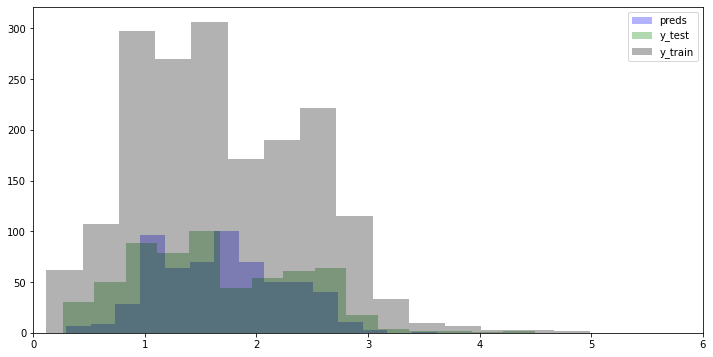

In [38]:
plt.figure(figsize=(12,6))
plt.hist(preds,   alpha=0.3,  bins = 15, color='blue' , label='preds')
plt.hist(y_test,  alpha=0.3,  bins = 15, color='green', label='y_test')
plt.hist(y_train, alpha=0.3,  bins = 15, color='black', label='y_train')

plt.legend()
plt.xlim((0,6))

In [39]:
print('y_test:', np.median(y_test.flatten()))
print('pred:', np.median(preds.flatten()))
print('y_train:', np.median(y_train.flatten()))

y_test: 1.5451
pred: 1.6662996
y_train: 1.5699


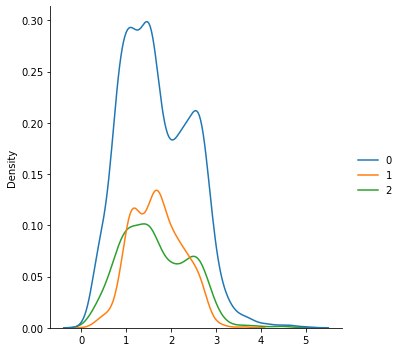

In [40]:
sns.displot([y_train.flatten(), 
             preds.flatten(),
             y_test.flatten()], kind="kde")

(-3.0, 3.0)

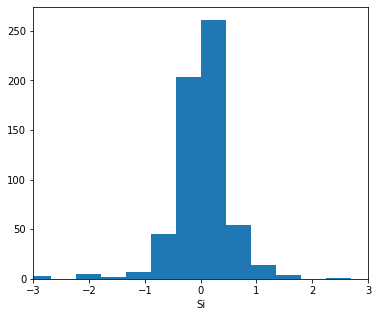

In [41]:
error = preds.flatten() - y_test.flatten()

plt.figure(figsize=(6,5))
plt.hist(error, bins=13)
plt.xlabel('Si')
plt.xlim((-3,3))

In [42]:
model1.feature_importances_

array([0.11009468, 0.04577102, 0.04548767, 0.04711553, 0.0512897 ,
       0.03655924, 0.05589751, 0.06457079, 0.08624782, 0.02707921,
       0.38299608, 0.04689072], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

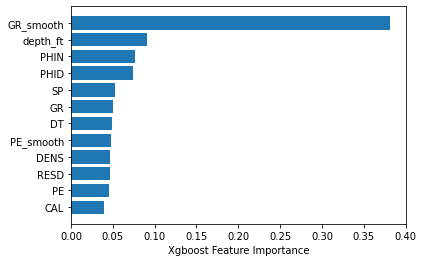

In [28]:
sorted_idx = model1.feature_importances_.argsort()

plt.barh(X.columns[sorted_idx], model1.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")